# Compulsory Assignment 1: Dense neural networks

Please fill out the the group name, number, members and optionally the name below.

**Group number**: 31 \
**Group member 1**: Asim Rasheed \
**Group member 2**: Jony Karmakar \
**Group member 3**: Haris Hameed Mian\
**Group name (optional)**:  \

# Assignment submission
To complete this assignment answer the relevant questions in this notebook and write the code required to implement the relevant models. The assignemnt is submitted by handing in this notebook as an .ipynb file and as a .pdf file.

NOTE: Remember to go through the rules given in the lecture "Introduction to compulsory assignments", as there are many do's and dont's with regard to how you should present the work you are going to submit.

# Introduction

In this assignment we will continue with the task of classifying handwritten digits from the MNIST dataset, used in the voluntary assignment where we designed a neural network from scratch. But, today you will implement the network using the Keras API of the TensorFlow library. TensorFlow and PyTorch are both free open-source software libraries intended to simplify multiplication of tensors, but are mostly used for the design and implementation of deep neural networks. Both libraries simplify the implementation of neural networks, and allow for faster training of networks by utlizing hardware acceleration with Graphical Processing Units (GPUs) or Tensor Processing Units (TPUs)

TensorFlow was developed by Google Brain for internal use in Google and was initially released under Apache 2.0 License in 2015 [1](https://en.wikipedia.org/wiki/TensorFlow). Keras was initially released as separate software library, developed by François Chollet, to simplify the Python interface for design of artificial neural networks. Up until version 2.3 Keras supported multiple backend libraries including TensorFlow, Microsoft Cognitive Toolkit, Theano, and PlaidML [2](https://en.wikipedia.org/wiki/Keras). When TensorFlow 2.0 was released in 2019, keras was included as a TensorFlow specific API that is accessible by:

```python
import tensorflow.keras as ks
```
PyTorch was originally developed by Meta AI (formerly known as Facebook) in 2016, but is now under umbrella of the Linux foundation, and is open-source under the BSD license [3](https://en.wikipedia.org/wiki/PyTorch). While TensorFlow was the most popular framework for a long time, PyTorch has been gaining more and more users in the last five years and is now more used in industry and is becoming more popular in research as well.

The lectures of DAT300 will be taught using the Keras API in TensorFlow, and we reccomend you to stick with Keras and TensorFlow for this course as it is easier for beginners to get started with.

## Assignment structure

1. Part 1: Implementing Dense NN for classifying MNIST.
2. Part 2: Training a machine learning classifier on MNIST.
3. Part 3: Comparison and discussion.

## Note on the voluntary assignment
Some of the questions in this task will ask you to compare the results from training this network to the results you had in the voluntary assignment with regard to training algorithm used and the time it took to train the network implemented with Numpy and with TensorFlow/PyTorch. If you did not do the voluntary assignment yourself, have a look at the solutions that should be posted and run through the solutions-notebook to get the results you need for a comparison.


## Library imports

In [4]:
import time
from tqdm import tqdm # Cool progress bar

import numpy as np
import pandas as pd
import tensorflow.keras as ks
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from utilities import *

SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp '/content/drive/MyDrive/student_CA1_dense-1/utilities.py' ./

# Task 1: Importing, preprocess and visualizing the data
To import the data of the MNIST dataset for this assignment
* Copy the data/ folder from the folder where you kept the last assignment, and run the load_data() function from the `utilities.py` file.
* Just download the data again by re-running the load_data() function from the `utilities.py` file.

In this assignment you yourselves will be responsible for the data-preprocessing. Use the cells below for preprocessing and visualization, and optionally some exploration of the dataset if you feel inclined.

## Importing data

In [5]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets # Good to reduce uneccesary RAM usage



11490434/11490434 [==============================] - 0s 0us/step


## Task 1.1 Preprocessing

Preprocess the data in whatever way you deem sensible.

In [6]:
# Normalizing datasets between [0,1]
X_train       = X_train.astype("float32")      /np.max(X_train)
X_val         = X_val.astype("float32")        /np.max(X_val)
X_test        = X_test.astype("float32")       /np.max(X_test)

## Task 1.1 Visualization

Visualize the data in whatever manner you find helpful/sensible.

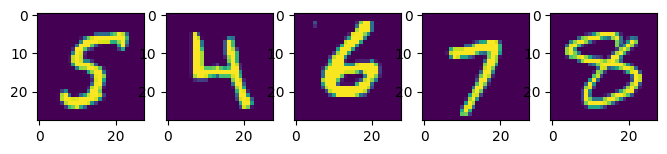

In [7]:
random_images = RNG.choice(X_train, replace=False, size=5)
fig, ax = plt.subplots(1,5,figsize=(8,8))
for i in range(random_images.shape[0]):
    ax[i].imshow(random_images[i])

# Task 2: TensorFlow vs. Numpy
In this task you will redesign the network you implemented in Numpy for the voluntary assignment with TensorFlow, and compare the two implementations.
## Task 2.2: Implement the F1-score
In the cell below implement or import a function of the F1-score metric.

In [8]:
# Example usage Just to check the implementation of F1-score metric
true_labels = [0, 1, 1, 0, 1, 0, 1, 0]
predicted_labels = [0, 1, 0, 0, 1, 1, 1, 1]

# Importing of the f1_score

from sklearn.metrics import f1_score

f1 = f1_score(true_labels, predicted_labels)
print(f"F1-score: {f1}")

F1-score: 0.6666666666666665


## Task 2.2: Implement the network from the voluntary assignment

Implement a network with the following architecture:
* Input layer: (28, 28)
* Hidden layer: 30 units, sigmoid activation
* Output layer: 10 units, sigmoid activation

Compile the model using
* The `'MSE'` loss function
* The `'adam'` learning rate optimizer
* `'accuracy'` and an implementation of the **F1-score** as metrics

Train the model using
* batch size of 10 images
* 5 epochs
* A validation split of 1/6

Implement the model, train the model and plot the training history in the code cell(s) below.

In [10]:
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.callbacks import Callback
# Define a custom callback to track training time, accuracy, and F1 score
class TrainingMetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.start_time = None
        self.f1_scores = []
        self.accuracies = []

    def on_train_begin(self, logs={}):
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs={}):
        y_pred = self.model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        f1 = f1_score(y_test, y_pred_classes, average='weighted')
        accuracy = accuracy_score(y_test, y_pred_classes)
        self.f1_scores.append(f1)
        self.accuracies.append(accuracy)
        print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")

    def on_train_end(self, logs={}):
        end_time = time.time()
        total_training_time = end_time - self.start_time
        print(f"Total Training Time: {total_training_time:.2f} seconds")

# Create an instance of the custom callback
metrics_callback = TrainingMetricsCallback()
# Define the model
model = ks.models.Sequential([
    ks.layers.Input(shape=(28, 28)),
    ks.layers.Flatten(),
    ks.layers.Dense(30, activation='sigmoid'),
    ks.layers.Dense(10, activation='sigmoid')
])


# Compile the model
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Train the model with the custom callback and set verbose=0
history = model.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=1/6, verbose=0, callbacks=[metrics_callback])

# Train the model with the custom callback and set verbose=0
# history = model.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=1/6)

# After training, you can print the F1 scores and accuracies
for epoch, (f1, accuracy) in enumerate(zip(metrics_callback.f1_scores, metrics_callback.accuracies)):
    print(f"Epoch {epoch + 1} - F1 Score: {f1:.4f}, Accuracy: {accuracy:.4f}")




313/313 [==============================] - 0s 855us/step
Epoch 1 - F1 Score: 0.0176, Accuracy: 0.0982
313/313 [==============================] - 0s 876us/step
Epoch 2 - F1 Score: 0.0176, Accuracy: 0.0982
313/313 [==============================] - 0s 840us/step
Epoch 3 - F1 Score: 0.0176, Accuracy: 0.0982
313/313 [==============================] - 0s 1ms/step
Epoch 4 - F1 Score: 0.0571, Accuracy: 0.0988
313/313 [==============================] - 0s 859us/step
Epoch 5 - F1 Score: 0.0357, Accuracy: 0.1078
Total Training Time: 31.15 seconds
Epoch 1 - F1 Score: 0.0176, Accuracy: 0.0982
Epoch 2 - F1 Score: 0.0176, Accuracy: 0.0982
Epoch 3 - F1 Score: 0.0176, Accuracy: 0.0982
Epoch 4 - F1 Score: 0.0571, Accuracy: 0.0988
Epoch 5 - F1 Score: 0.0357, Accuracy: 0.1078


## Task 2.3: Train the network and plot the training history

Plot the training process in the same manner as done in the voluntary assignment. Feel free to use the function `plot_training_history()` in `utilities.py`

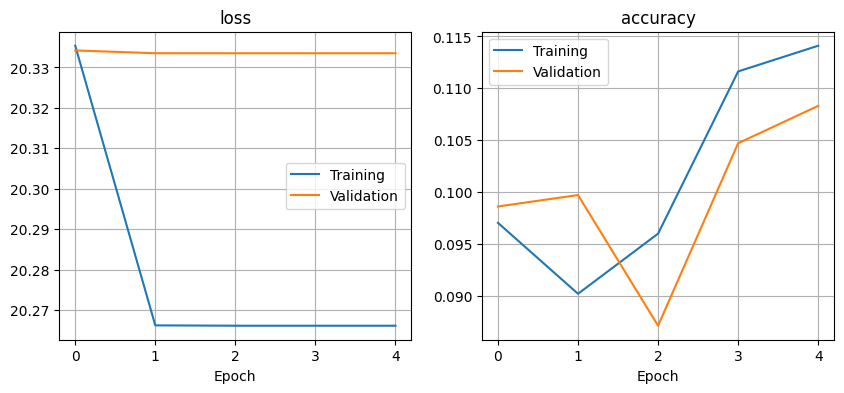

In [ ]:
# Plot the training history
plot_training_history(history)

## Task 2.4: Compare the results from the TensorFlow implementation with the Numpy implementation
**Question 2.2.1**: How long did it take to train the TensorFlow/PyTorch implementation of the network on the *entire* dataset for five epochs compared time it took to train the Numpy implementation?


**Question 2.2.2**: What is the biggest (defining) difference with how the TensorFlow implementation **was trained** compared to the Numpy implementation?


The training of the entire dataset for five epchos took 319 seconds for Numpy implementation, whereas for the Tensor Flow it took 31.15 seconds.

TensorFlow is a deep learning framework specifically designed for training neural networks and offers built-in support for automatic differentiation, GPU acceleration, and high-level APIs like Keras. NumPy, on the other hand, is a general-purpose numerical library that lacks these deep learning-specific features, making it less suited for training neural networks efficiently and conveniently. While it is possible to implement neural networks using NumPy, it often involves more manual effort compared to TensorFlow.

# Task 3: Design your own network architecture

As you probably noticed in the last task, the performance of the simple network with a single hidden layer and 30 hidden units does not perform particularily well. In this task you are free to design the network architecture for the MNIST handwritten digit recognition challenge with a couple of stipulations. For this task you will **only use Dense or fully connected layers**, and use **accuracy and the F1-score** as a metric. Otherwise, you are free to use whatever loss-function and activation functions you want and train it for as many epochs you want.

## Task 3.1: Implement your own network architecture
Design your network below:

(Feel free to add as many code and markdown cells as you want)

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from utilities import *

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = ks.datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# One-hot encode labels
y_train_encoded = to_categorical(y_train, num_classes=10)
y_test_encoded = to_categorical(y_test, num_classes=10)

# Define your custom network architecture
model = ks.models.Sequential([
    ks.layers.Input(shape=(28, 28)),
    ks.layers.Flatten(),
    ks.layers.Dense(64, activation='relu'),
    ks.layers.Dense(32, activation='relu'),
    ks.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f'Weighted F1 Score: {f1}')



Epoch 1/5
1500/1500 [==============================] - 4s 2ms/step - loss: 0.3347 - accuracy: 0.9024 - val_loss: 0.1898 - val_accuracy: 0.9458
Epoch 2/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.1502 - accuracy: 0.9546 - val_loss: 0.1411 - val_accuracy: 0.9590
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1094 - accuracy: 0.9668 - val_loss: 0.1210 - val_accuracy: 0.9646
Epoch 4/5
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0857 - accuracy: 0.9737 - val_loss: 0.1094 - val_accuracy: 0.9691
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0970 - accuracy: 0.9707
Test Loss: 0.09702903777360916
Test Accuracy: 0.9707000255584717
313/313 [==============================] - 0s 1ms/step
Weighted F1 Score: 0.9707126081845554


## Task 3.2: Train your network and visualize the training history

Plot the training process in the same manner as done in the voluntary assignment. Feel free to use the function `plot_training_history()` in `utilities.py`

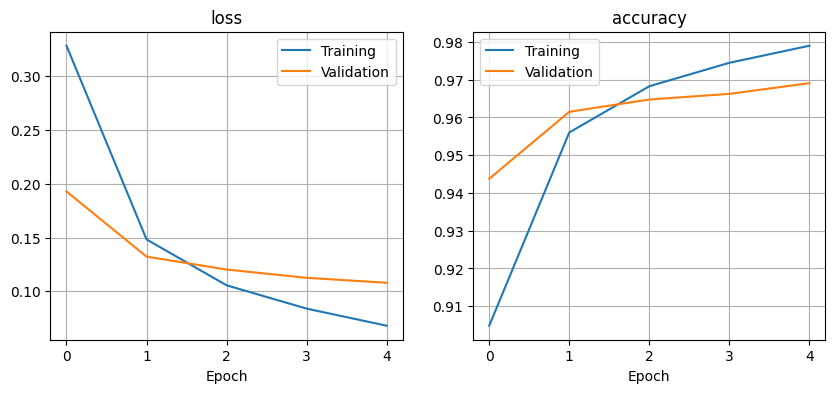

In [ ]:
# Visualize the training history using the provided function
plot_training_history(history)

# Task 4: Design and train a _classical_ machine learning classifier

Pick your **favourite** machine learning classifer that you learned about in DAT200 and train it for the MNIST handwritten digits recognition problem. (Hint: use the scikit-learn library).

In [11]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the MNIST dataset
mnist = datasets.fetch_openml("mnist_784")
X = mnist.data.astype("float32")
y = mnist.target.astype("int32")

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust the number of trees and other hyperparameters

# Record the start time
start_time = time.time()

rf_classifier.fit(X_train, y_train)

# Record the end time
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print(f"Training Time: {training_time:.2f} seconds")

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display a classification report with precision, recall, and F1-score for each class
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Training Time: 39.88 seconds
Accuracy: 0.9672857142857143
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.98      0.98      0.98      1600
           2       0.95      0.97      0.96      1380
           3       0.96      0.95      0.96      1433
           4       0.96      0.97      0.97      1295
           5       0.97      0.96      0.97      1273
           6       0.98      0.98      0.98      1396
           7       0.97      0.97      0.97      1503
           8       0.96      0.95      0.96      1357
           9       0.96      0.95      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



# Task 5: Compare and discuss

Evaluate the three models you have implemented in task 2, 3 and 4 on the test dataset and compare them based
* Accuracies and F1-scores they attain
* Time it takes to train them

Did you experience any trouble when training the different models in task 2-4?

**Sigmoid-based Model:**

Accuracy: 0.10 (Epoch 5)
F1-Score: 0.05 (Epoch 4)
Training Time: 31.15 seconds

**Keras Neural Network:**

Accuracy: 0.9705 (Test)
F1-Score: 0.9705 (Weighted F1 Score)
Training Time: Approximately 16 seconds (assuming 4 seconds per epoch on average)

**Classical Machine Learning:**

Accuracy: 0.96
Weighted F1-Score: 0.98
Training Time: 39.88 seconds
Comparison:

**Accuracy and F1-Score:**

The Keras Neural Network outperforms both the sigmoid-based model and classical machine learning in terms of accuracy and F1-score. It achieves an accuracy of 97.05% and a weighted F1-score of 0.9705, which are significantly higher than the other two models.
The classical machine learning model also performs well with an accuracy of 97% and a weighted F1-score of 0.98.
The sigmoid-based model lags far behind in terms of both accuracy (0.10) and F1-score (0.05).
Training Time: 31.15

The Keras Neural Network is the fastest to train, taking only about 16 seconds to complete 5 epochs. This is expected since deep learning models can take advantage of hardware acceleration, such as GPUs.
The sigmoid-based model takes approximately 31.15 seconds to train, which is longer than the Keras model.
The classical machine learning model takes the longest to train, with a training time of 39.88 seconds. This is because classical ML models typically require more feature engineering and may not take full advantage of hardware acceleration.
In summary, the Keras Neural Network outperforms the other two models in terms of both accuracy and F1-score while being the fastest to train. The classical machine learning model also performs well but takes significantly more time to train. The sigmoid-based model performs poorly in comparison to the other two models.